<a href="https://colab.research.google.com/github/EdgarIvanHR/NLP/blob/main/Copia_de_Topic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'blog-authorship-corpus:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1968%2F3381%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240804%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240804T085126Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9fb0a5c9a2b4b7a47c08a6f405f81681b1fa81730a18576de0d3502cc80602f1c182e521cb8dc0c2d8350099dbf1eb2799656a4414ac59ab872d9a595e538a49fda05621aba2b3fc7ca7a9632fc466c4c2a76de5ae2c11451e18adf52bdb05eabdc34ea513c57ba206a5b7e4e2330863efe8d8e926a53079f0ee3a12651ec08636e865e7703e1ff7b1de9bbfc30400eeca454800e70206f34316163c50889cc711ec6ffe56dcdc1ee22b9b9e22ec71f48bbc7d0be6ab86741302e3da978501b012d8898d7a4db9b9fb541074e87a93c4661bb9cdcf5d35ea736ed6b6ac1c35e22c735743cf82a2a42049879dd0dcad1d11078a60497c42409d1f5a2825b3a58d,big-dos-train:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5450796%2F9041342%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240804%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240804T085127Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03f58666109b55bfa7ea8451cda9490d419b5d1f409c008290688507ca96369e09110e92418528c325b30e49cec142d88646874d697939dd9dd53fcb4825f52f3fc14c893b2b462e991d4ed4964c810f123fe9178db49a22109cca674ae63e8b4ee73f0156d4825339f19491bea762f4436cedc76d4086f4fbe5445d440aab4a052267b4469161344ba96b4cf0f7e46105a8c6571fc371621900da781437e0176f74896bfe3f365c606c36ca26e54dd35b6e9612a44c0c0a53f681eeb481b1aa1478fa54236005d2cb88abe1bf19366af602d7318acbae162a12bec0324fe2a2a5cc2643c39fabade2b7803240cc6cb839ec42292379790056a3ad8793765ba0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 303646744 bytes downloaded
Downloaded and uncompressed: blog-authorship-corpus
[==================================================] 6214454 bytes downloaded
Downloaded and uncompressed: big-dos-train
Data source import complete.


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import operator
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from plotly import express as ex
import time
from tqdm import tqdm

# **Breve descripción de los datos**

Los datos son posteos de blogs hechos hasta antes de agosto del  2004 en la página "blogger.com". Contiene un total de 681288 post provenientes de 19320 usuarios diferentes con al rededor de 140 millones de palabras en total.


Los datos vienen en una tabla de excel donde cada renglón describe un posteo en el blogg. Las características medidas de cada posteo son: id (el id del usuario que hizo el post), gender (género del usuario), age (edad del usuario), topic (no es el tópico del post como tal, más bien es el estatús del usuario. Si es estudiante, personal de la industria, etc.), sign (signo sodiacal), date (fecha del posteo) y text (texto del posteo).


El enlace a los datos originales es: https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus

Leemos los datos y los guardamos en un data frame de pandas.

In [ ]:
import pandas as pd

DATA = pd.read_csv("/kaggle/input/blog-authorship-corpus/blogtext.csv")

Así se ve una entrada del data frame de datos

In [ ]:
DATA.loc[100]

id                                                  3668238
gender                                               female
age                                                      17
topic                                               Student
sign                                                 Gemini
date                                           23,June,2004
text                       i can't wait for things to ge...
Name: 100, dtype: object

¿Qué pasa si nos restringimos a un rango de edad?

Ya que vamos a hacer análisis de tópicos, los resultados serán más coherentes si nos restringimos por rangos de edades, pues personas de 13 a 17 años hablarán de temas muy distintos a personas de 30 a 40 años de edad.

In [ ]:
DATA = DATA.query("age <= 17 and age >=13")

In [ ]:
set(DATA["age"])

{13, 14, 15, 16, 17}

Describiendo un poco el conjunto de datos. Se muestran el promedio  y un histograma de la distribución de blgos por persona.

Número de blogs:  235867 , Cantidad de bloggers:  8240
Promedio de bloggs por persona:  28.624635922330096


(array([8.111e+03, 8.900e+01, 2.100e+01, 3.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([1.0000e+00, 2.2530e+02, 4.4960e+02, 6.7390e+02, 8.9820e+02,
        1.1225e+03, 1.3468e+03, 1.5711e+03, 1.7954e+03, 2.0197e+03,
        2.2440e+03]),
 <BarContainer object of 10 artists>)

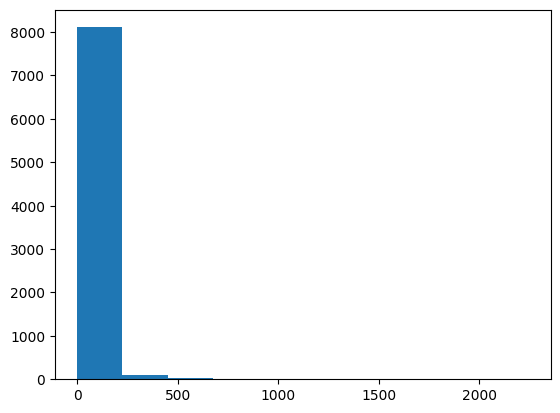

In [ ]:


N_blogs, N_bloggers = DATA.shape[0], len(set(DATA.loc[:]["id"]))
print("Número de blogs: ", N_blogs, ", Cantidad de bloggers: " , N_bloggers)
print("Promedio de bloggs por persona: ", N_blogs/N_bloggers )
frecuencias_bloggs = dict()
for id in set(DATA.loc[:]["id"]):
    frecuencias_bloggs[id] = DATA[DATA.id == id].shape[0]

fig, ax = plt.subplots()
ax.hist(list(frecuencias_bloggs.values()))



Vemos que existen usuarios con muchísimas entradas en el blog. Un histograma excluyendo al 1% de usuarios con más entradas en el blog es el siguiente:

Los deciles son:  [3.0, 4.0, 6.0, 8.0, 10.0, 13.0, 19.0, 29.0, 56.0]


(array([5862., 1161.,  405.,  202.,  130.,  101.,   67.,   43.,   42.,
          34.]),
 array([  1. ,  19.6,  38.2,  56.8,  75.4,  94. , 112.6, 131.2, 149.8,
        168.4, 187. ]),
 <BarContainer object of 10 artists>)

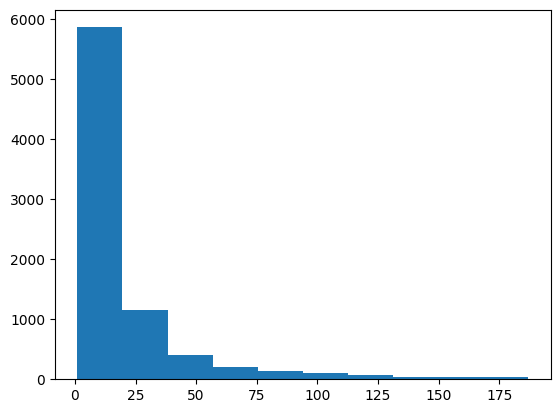

In [ ]:
import statistics as st
import operator

print("Los deciles son: ",st.quantiles(list(frecuencias_bloggs.values()),n = 10))

frecuencias_bloggs = dict(sorted(frecuencias_bloggs.items(), key=operator.itemgetter(1),reverse = True))
fig, ax = plt.subplots()
ax.hist(list(frecuencias_bloggs.values())[int(19320*.01):])


Distribución de palabras por blogg

# **Representación de documentos y eligiendo el vocabulario**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df= 10,token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',use_idf = False,norm =  None)
# En este caso es más eficiente hacer el ajuste (fit) y la transformación
# (transform) del texto a matriz de documento-término.
matrix_frecuency =  vectorizer.fit_transform(DATA["text"])
print(matrix_frecuency.shape)

(235867, 48638)


Queremos reducir el número de términos en nuestro vocabulario, pues muchos de ellos serán usados pocas veces e incluirlos no representaría una mejora sutancial para la detección de tópicos.

In [ ]:
complete_vocabulary = vectorizer.get_feature_names_out()
complete_freq_words = np.sum(matrix_frecuency,axis = 0).tolist()[0]

sorted_vocab_freq = sorted(zip(complete_vocabulary,complete_freq_words), key=lambda a: a[1],reverse = True)

vocabulary,freq_words =zip(*sorted_vocab_freq)

for a in zip(vocabulary[:10],freq_words[:10]):
    print(a[0],a[1],"\n")

# quitamos la palabra urlink que se usa para denotar links en los post
vocabulary = set(vocabulary[:9000]) -  set(["urllink","nbsp"])

like 237079.0 

just 210703.0 

nbsp 161576.0 

really 140759.0 

know 139030.0 

don 119632.0 

got 118799.0 

time 116250.0 

think 112113.0 

good 100588.0 



Comparemos la distribución Cantidad de Palabras Por Documento (CPPD) para investigar qué tanto afecta el restringirnos a un vocabulario más pequeño.

Vemos que la distribución no cambia demasiado.

(235867, 48638)
Los deciles son:  [6.0, 13.0, 23.0, 35.0, 49.0, 67.0, 90.0, 123.0, 187.0]
(235867, 8998)
Los deciles son:  [5.0, 11.0, 20.0, 31.0, 44.0, 60.0, 81.0, 111.0, 168.0]


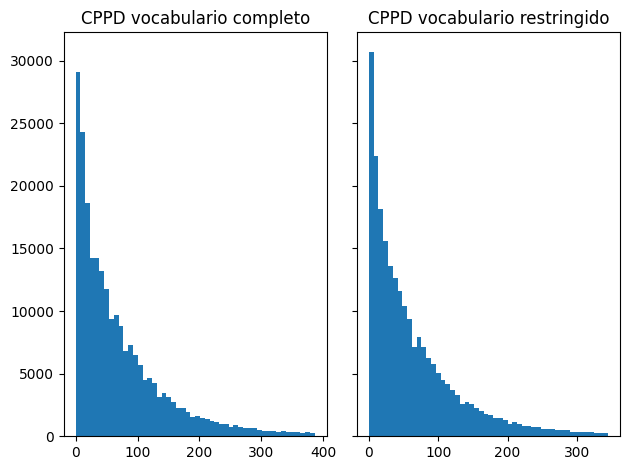

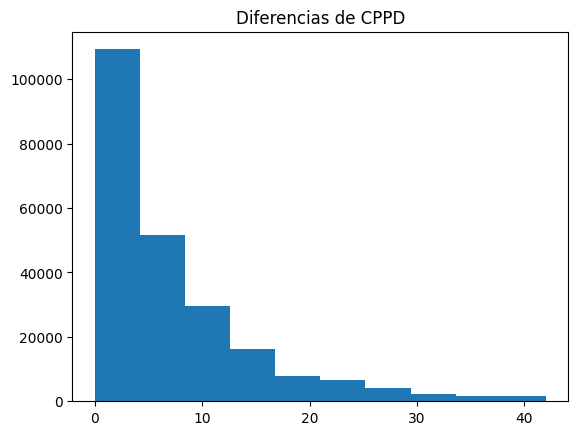

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df= 10,token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',use_idf = False,norm =  None)
# En este caso es más eficiente hacer el ajuste (fit) y la transformación
# (transform) del texto a matriz de documento-término.
matrix_frecuency =  vectorizer.fit_transform(DATA["text"])
print(matrix_frecuency.shape)


document_frec_words_complete = matrix_frecuency.sum(axis = 1).flatten()
d = sorted(document_frec_words_complete.tolist()[0])
print("Los deciles son: ",st.quantiles(d,n = 10))


# USANDO EL VOCABULARIO DE LAS 25000 PALABRAS MÁS FRECUENTES

vectorizer2 = TfidfVectorizer(token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',use_idf = False,norm =  None,vocabulary=vocabulary)
# En este caso es más eficiente hacer el ajuste (fit) y la transformación
# (transform) del texto a matriz de documento-término.
matrix_frecuency2 =  vectorizer2.fit_transform(DATA["text"])
print(matrix_frecuency2.shape)


document_frec_words = matrix_frecuency2.sum(axis = 1).flatten()
d2 = sorted(document_frec_words.tolist()[0])
print("Los deciles son: ",st.quantiles(d2,n = 10))


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(d[:int(.98*len(d))], bins=50)
axs[1].hist(d2[:int(.98*len(d2))], bins=50)
axs[0].set_title("CPPD vocabulario completo")
axs[1].set_title("CPPD vocabulario restringido")

plt.show()

fig, ax = plt.subplots()
ax.hist(np.array(d[:int(.98*len(d))])-np.array(d2[:int(.98*len(d2))]))
ax.set_title("Diferencias de CPPD")
plt.show()

# **Análisis de tópicos**

Ya que hemos visto que restringirnos a un vocabulario más pequeño no afecta demasiado la distribución de palabras por documento, entonces toca hacer la representación de documento-término.

Esta representación se encuentra alojada en la matriz sparse "matrix_representation" cuyas dimensiones son, precisamente, el número de documentos por el número de términos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# El vectorizador  de sklearn se ajusta después. Cuando se instancía
# este recibe parámetros importantes como: token_pattern que es el patrón
# sobre el cual se extraen las palabras en el texto. También le puedes pasar como
# parámetros funciones para procesar las cadenas de texto o si quieres que todo
# el texto se transforme a minúsculas. Dejando de lado la parte del procesamiento
# de texto, esta función también te permite elegir el esquema de pesado
# para la representación de documentos.
# Aquí cambiamos la expresión regular para buscar las palabras del texto,
# pues orignalmente era r”(?u)\b\w\w+\b” que busca cadenas alfanuméricas
# de longitud al menos igual a dos. En nuestro caso, buscamos cadenas
# alfabéticas de cualquier longitud
vectorizer = TfidfVectorizer(token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',vocabulary=vocabulary)
# En este caso es más eficiente hacer el ajuste (fit) y la transformación
# (transform) del texto a matriz de documento-término.
matrix_representation =  vectorizer.fit_transform(DATA["text"])
print(matrix_representation.shape)

(235867, 8998)


Para el topic modeling vamos a usar la factorización no negativa de la matriz de representación documento-término. Esta representación asume que cada documento (que originalmente se encuentra representado como un vector de tamaño igual al número de términos) vive en un espacio latente de menor dimensión (digamos, un espacio de k dimensiones con k < número de términos).

Es decir, asume que un documento "d" puede ser representado como combinación lineal de ciertos tópicos "u1,u2, ..., uk".

En este caso, exploraremos los reslutados de colocar k = 4 tópicos

In [ ]:
from sklearn.decomposition import NMF

n_comps = 5

model_NNMF = NMF(n_components=n_comps, init='random', random_state=0,max_iter = 400)
W = model_NNMF.fit_transform(matrix_representation)
H = model_NNMF.components_

Con esta descomposición no solamente podemos investigar la relación que tendrían los documentos con los tópicos, también se puede pensar a un tópico como una combinación de los términos que lo componen. De este modo, podemos asociar a cada tópico sus términos más relevantes y de este modo intentar darle un significado a cada elemento de la descompisición.

A continuación vemos las palabras más relacionadas (con mayores coeficientes en el vector de tópicos) a los 5 tópicos que se formaron.

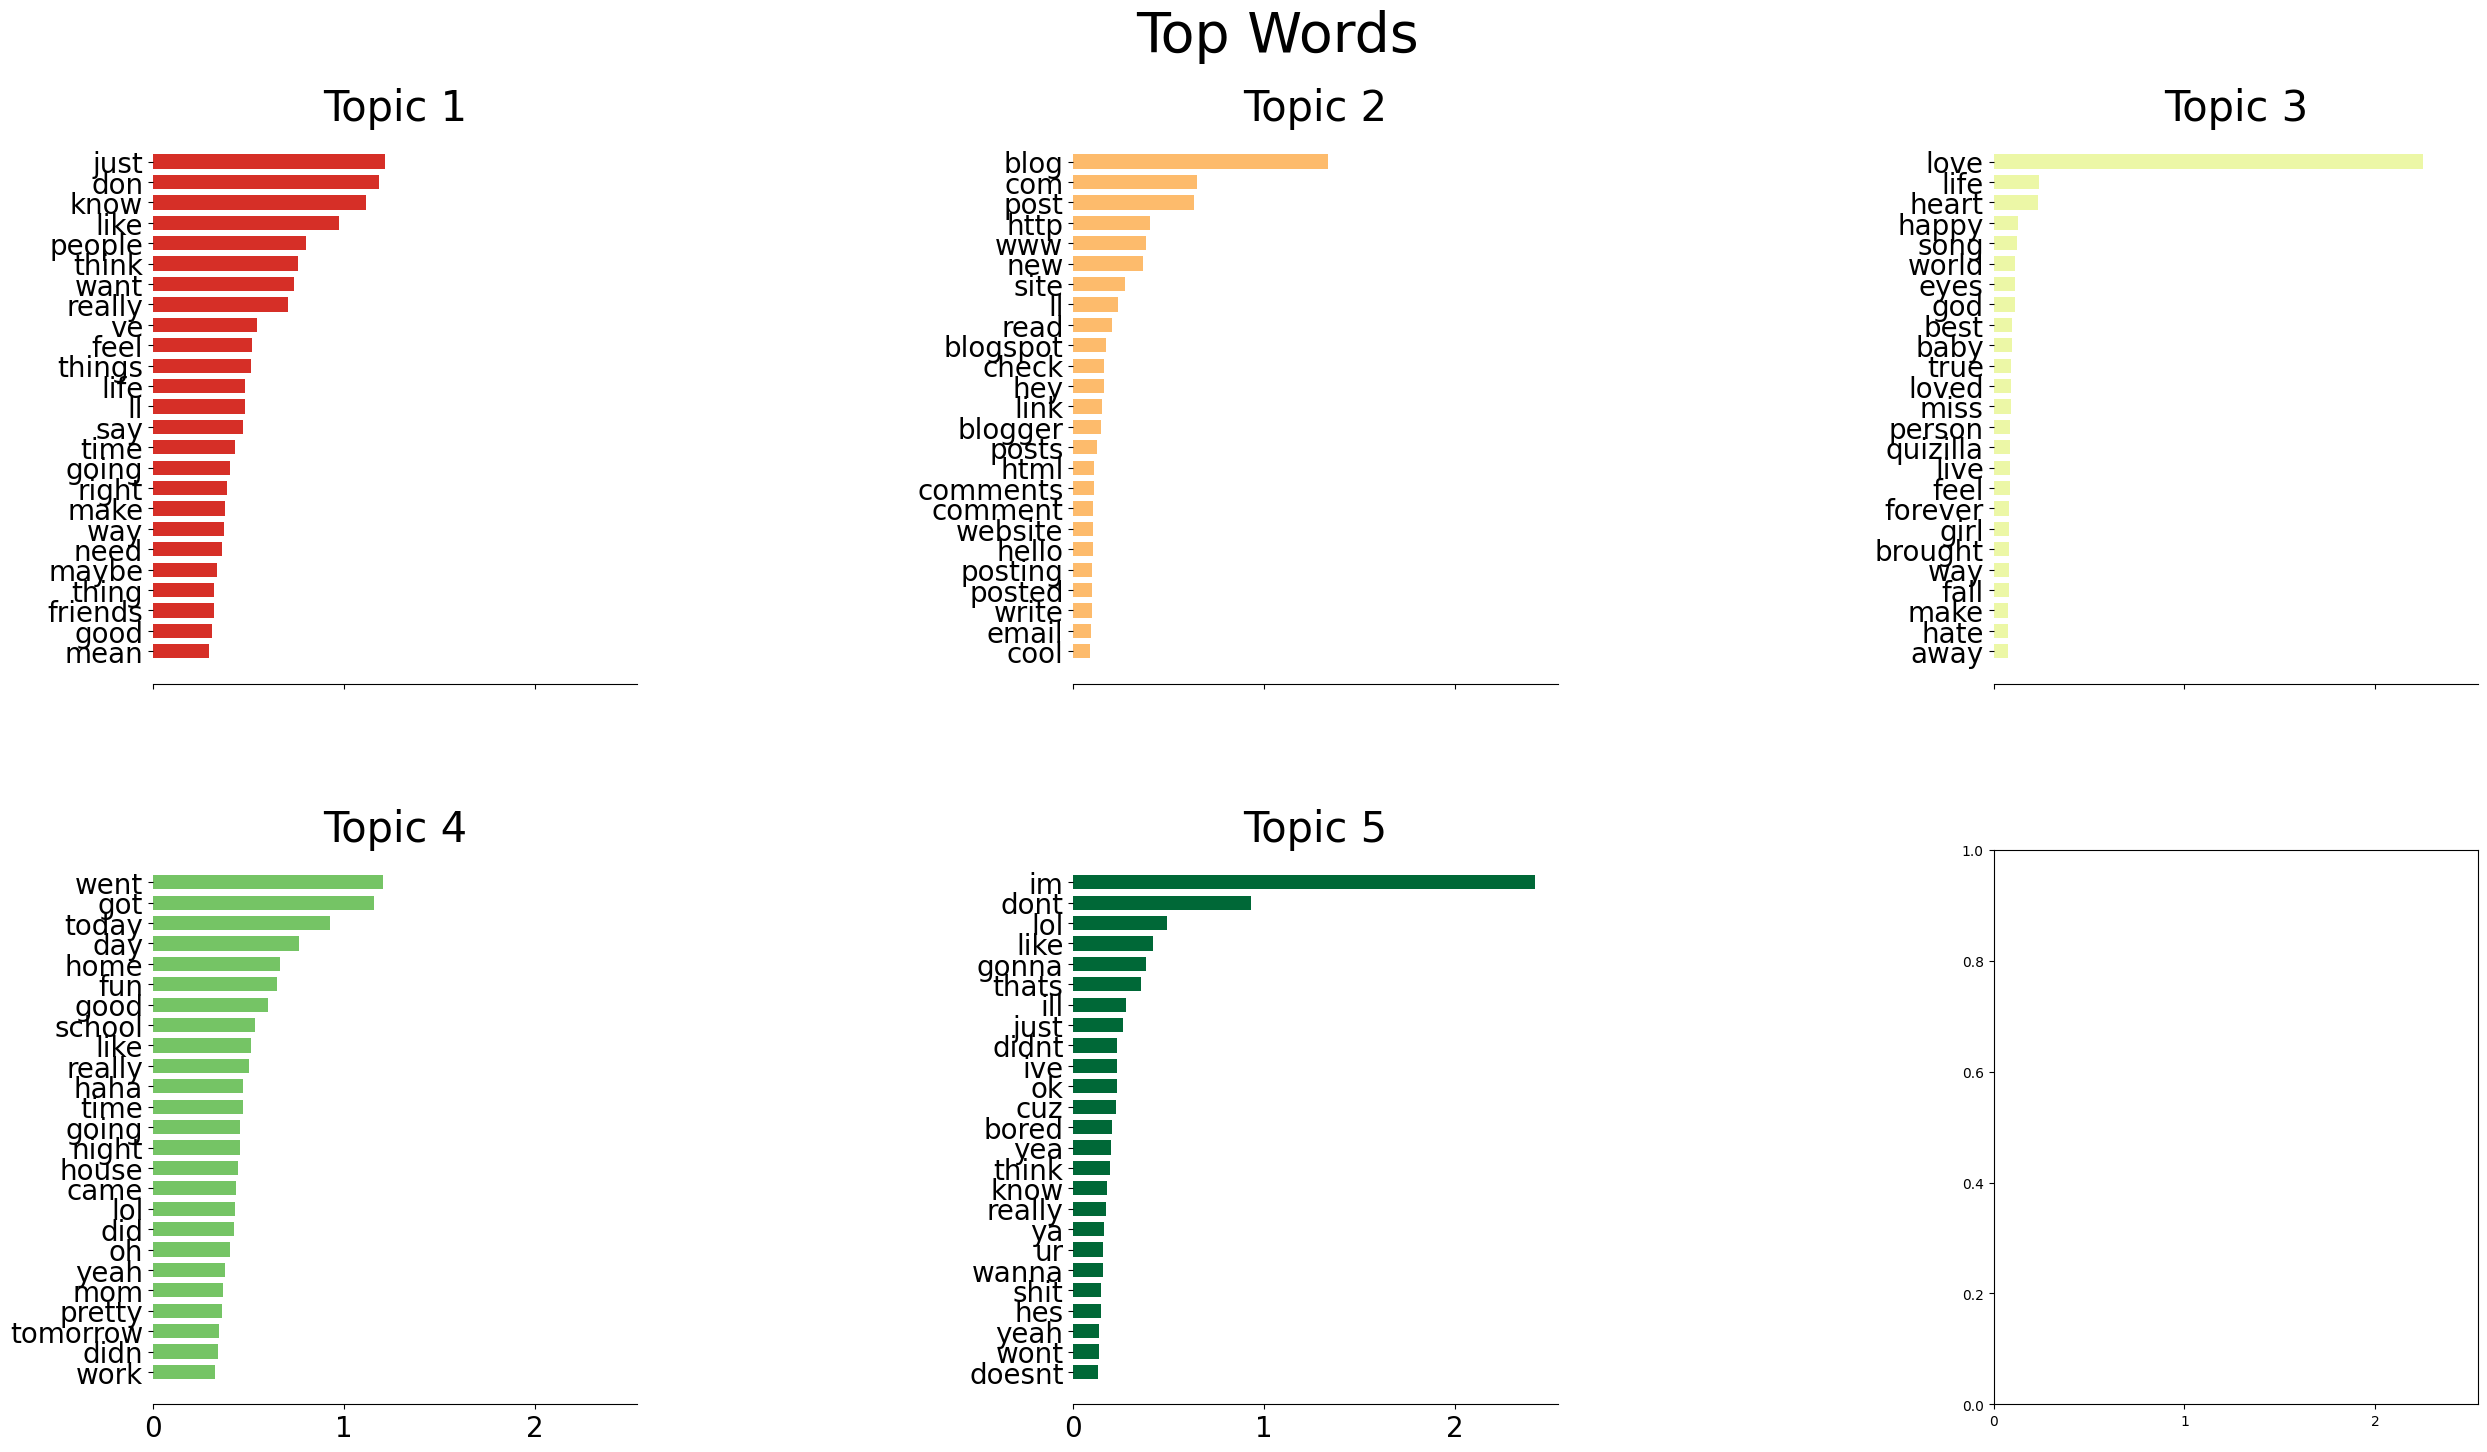

In [ ]:
colors = plt.colormaps['RdYlGn'](
        np.linspace(0.1, 1.0, n_comps))
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color = colors[topic_idx,:])
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
plot_top_words(model_NNMF,vectorizer.get_feature_names_out(),25,"Top Words")

Usando una modificación al pesado para hacer la representación de documento x término, tenemos los siguientes resultados

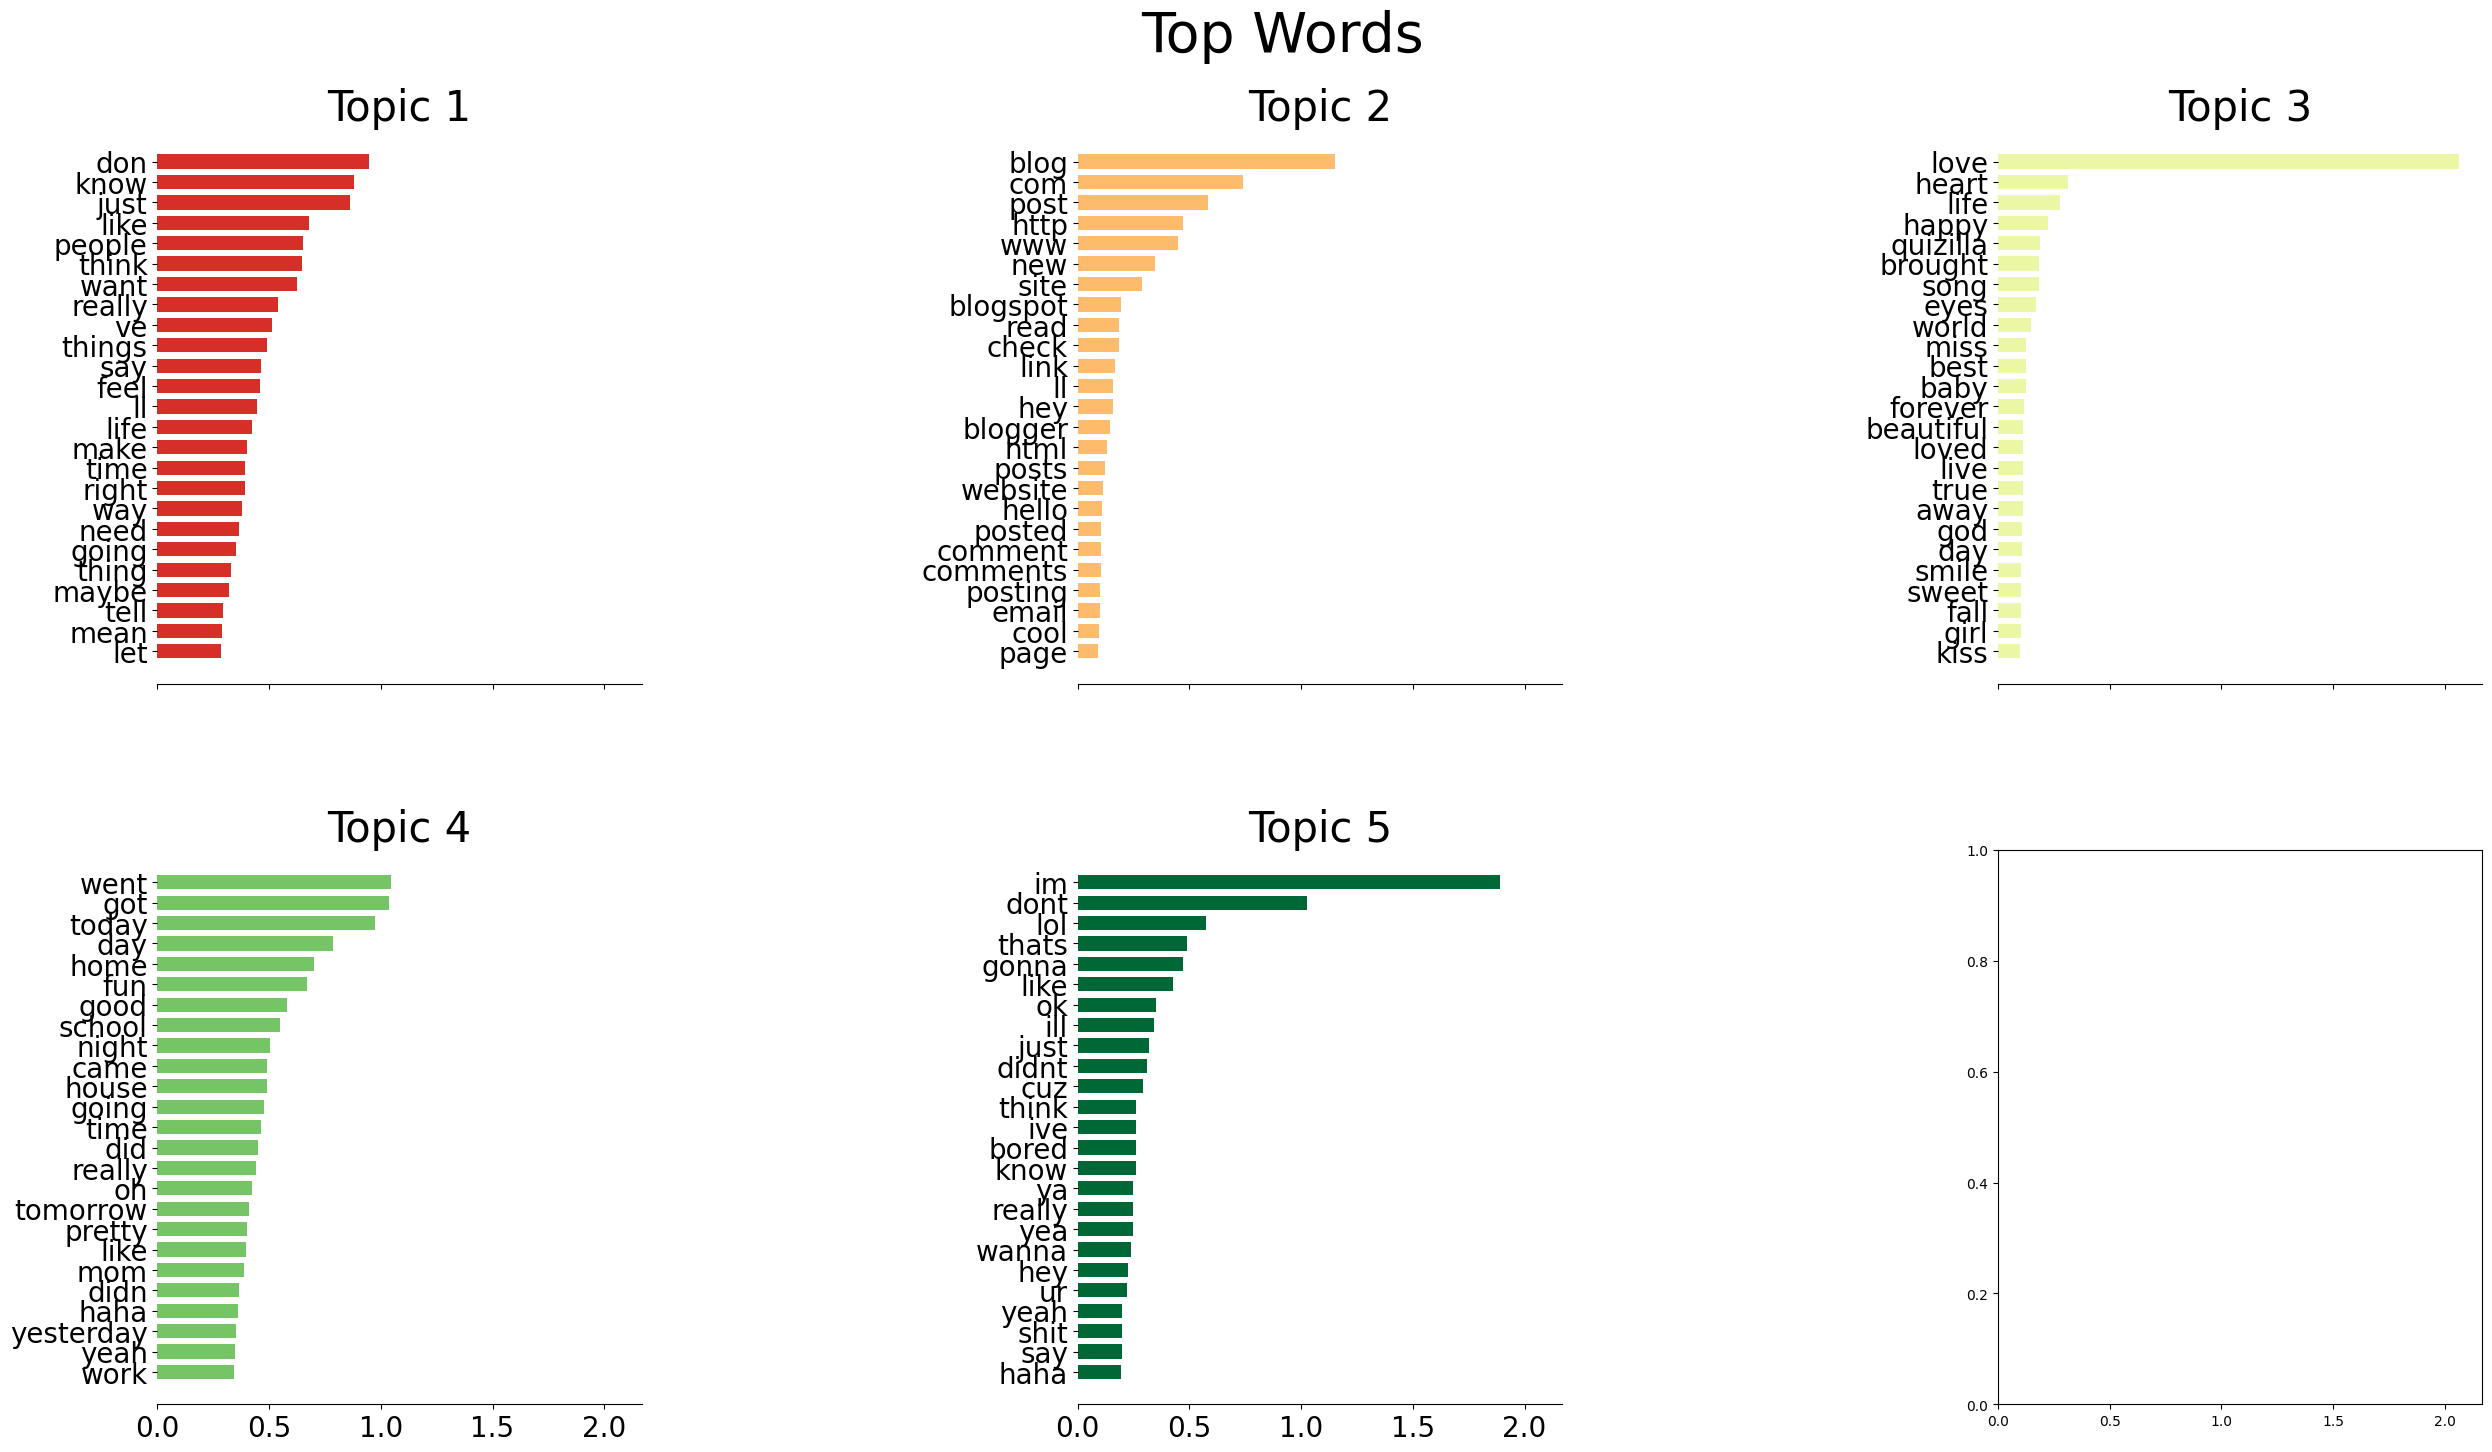

In [ ]:
vectorizer_SLtf = TfidfVectorizer(token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',vocabulary=vocabulary,sublinear_tf = True)
matrix_representation_SLtf =  vectorizer_SLtf.fit_transform(DATA["text"])
model_NNMF_SLtf = NMF(n_components=n_comps, init='random', random_state=0,max_iter = 400)
W_SLtf = model_NNMF_SLtf.fit_transform(matrix_representation_SLtf)
plot_top_words(model_NNMF_SLtf,vectorizer_SLtf.get_feature_names_out(),25,"Top Words")

Bajo los dos esquemas de pesado, se obtuvieron resultados bastante similares para las palabras más representativas de cada tópico.

Aunque esta es una herramienta bastante empleada en el análisi de tópicos, no necesariamente todos los "tópicos" formados por este método (y por ninguno) tendrán un verdadero significado. Por ejemplo, el tópico número uno contiene palabras muy genéricas y que no se especializan en nada en particular. Por otro lado, el tópico número dos tiene una clara interpretación, en él se hablan de cuestiones relacionadas al blog, páginas web y contenido en la red. El tópico número cuatro parece hablar de cuestiones cotidianas de los adolescentes (recordemos que al inicio de este análisis nos restringimos al rango de edad 13-17 años para que los temas de los que se hablacen fuesen más homogeneos). Puede que el tópico número cinco tenga conotaciones negativas, pues en él se encuentran palabras como "ill", "bored", "shit".

Es interesante ver cómo cambian estos tópicos al cambiar de rango de edades, los adultos menores (23-27 años) hablan de trabajo y los adultos (33-47 años) se les agrega un tópico de temas políticos. Este cambio en los tópicos se puede apreciar si cambiamos el rango de edades en el query del inicio.

# **Hard cluster a los documentos**

Gracias a su formulación, la descomposición no negativa de matrices nos permite otorgar a cada documento cierto grado de pertenencia para cada tópico. Dicho grado de pertenencia se obtiene al observar el coeficiente del vector de tópicos, mientras más grande el valor, mayor el grado de pertenencia.

Si hacemos un hard clustering, podemos otorgar a cada documento un único tópico.

Guardaremos las etiquetas para cada documento en la variable "etiquetas_blogs"

In [ ]:
def h_cluster(W):
    """
    W es la matriz de documentos x tópicos retornada al hacer NMF.fit_transform()
    """
    return np.argmax(W,axis = 1)

etiquetas_blogs = h_cluster(W_SLtf)
print("Las etiquetas son: ", set(etiquetas_blogs))

Las etiquetas son:  {0, 1, 2, 3, 4}


Podemos intentar  incrustar los datos de la bolsa de palabras (que es de dimensión 9000) en un espacio de dimensión 2 para visualizar los documentos con su etiqueta de tópico y


In [ ]:

n_docs = matrix_representation_SLtf.shape[0]

TSVD_model = TruncatedSVD(n_components = 50,n_iter=10)
#matrix_rep_reducida = TSVD_model.fit_transform(matrix_representation)
matrix_rep_reducida = TSVD_model.fit_transform(matrix_representation_SLtf)

print("Varianza explicada : ", np.sum(TSVD_model.explained_variance_ratio_))

np.random.seed(113)
MA = np.random.randint(0,n_docs,10000)
# 5000 se ve bien
# perplexity = 10
TSNE_blogg = TSNE(init = "random",perplexity= 5,early_exaggeration=20).fit_transform(matrix_rep_reducida[MA,:])
#TSNE_blogg = TSNE(init = "random",perplexity= 10).fit_transform(matrix_rep_reducida)

print(TSNE_blogg.shape)

Varianza explicada :  0.0827081344318255
(10000, 2)


In [ ]:
TSNE_blogg_NMF = TSNE(init = "random",perplexity= 5,early_exaggeration=20).fit_transform(W_SLtf[MA,:])
print(TSNE_blogg.shape)

(10000, 2)


t-SNE es una técnica de reducción de dimensionalidad ampliamente usada en la actualidad y esta permite incrustaciones en espacios de dos dimensiones que conservan ciertas estructuras del espacio original.

[Text(0.5, 1.0, 'Hard Cluster BOW')]

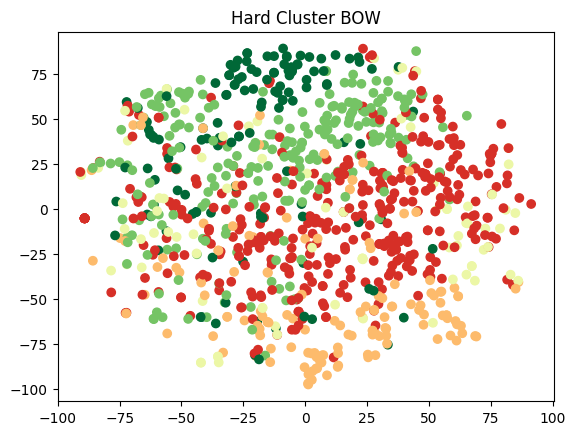

In [ ]:
np.random.seed(1637)
MA2 = np.random.randint(0,len(MA),1000)

#fig, ax = plt.subplots(1,2)
fig, ax = plt.subplots()
ax.scatter(TSNE_blogg[MA2,0],TSNE_blogg[MA2,1],c = colors[(etiquetas_blogs[MA])[MA2],:])
ax.set(title="Hard Cluster BOW")
#ax[1].scatter(TSNE_blogg_NMF[MA2,0],TSNE_blogg_NMF[MA2,1],c = colors[(etiquetas_blogs[MA])[MA2],:])
#ax[1].set(title="Hard Cluster NMF")

# **DOR**

In [ ]:

def DOR(BOW,df = "frecuencias",use_itf = True,normalize = True):
    """
    BOW :es la matriz de bolsa de palabras contando las frecuencias de
        las palabras en los documentos.

    df : frecuencias, binario o sub_linear.

    use_itf : bool
        usar o no itf
    """

    DOR_words = BOW.T

    if df == "sub_linear":
        # a las frecuencias les sacamos el logaritmo y les sumamos uno
        # esto solo acutaliza las entradas donde la matriz no es cero
        DOR_words[DOR_words.nonzero()] = np.log(DOR_words[DOR_words.nonzero()]) + 1.0
    elif df == "binario":
        # en el caso binario, las entradas no ceros (donde el témirno ocurrió
        # al menos una vez en el documento), se camiban a uno y las demás
        # se quedan en cero
        DOR_words[DOR_words.nonzero()] =  1.0

    # número de documentos y tamaño del vocabulario
    (D,T) = BOW.shape

    # las entradas de BoW_uno_cero son uno si el término se encuentra en el documento
    # y cero en caso contrario
    BoW_uno_cero = BOW.copy()
    BoW_uno_cero[BoW_uno_cero.nonzero()] =  1.0
    # sumamos por renglones (documentos) la cantidad de palabras diferentes
    # usadas en el documento.
    relative_vocab_length = BoW_uno_cero.sum(axis = 1)
    # los documentos que  no tengan representación en la BoW, les pondremos
    # un relative_vocab_length = 1 para evitar la división por cero
    # de cualquier manera, si ese documento (k-esimo) no tiene representación
    # entonces su valor en DOR_words[:,k] es cero para todos los términos
    relative_vocab_length[np.where(relative_vocab_length == 0.0)] = 1.0

    # multiplicamos cada entrada del DOR por su itf
    if use_itf == True:
        for k in range(D):
            DOR_words[:,k] = np.log(T/relative_vocab_length[k,0])*DOR_words[:,k]


    # utlizaremos esta matriz para normalizar
    DOR_aux = DOR_words.copy()
    DOR_aux = DOR_aux.multiply(DOR_aux)
    ctes_normalizacion = np.sqrt(DOR_aux.sum(axis = 1))

    # normalizamos los vectores de representación de témrinos
    if normalize == True:
        for j in range(T):
            DOR_words[j,:] = (1/ctes_normalizacion[j,0])*DOR_words[j,:]

    return DOR_words

"""
mini_corpus = ["Hola a todo el mundo a", "Más o menos las cosas","Si a no interrumpir o a"]
# use_idf = False y norme = None para obtener solo frecuencias.
vect = TfidfVectorizer(token_pattern = r"(?u)\b[a-z]+\b",lowercase= True,use_idf= False,norm=None)
mini_bow = vect.fit_transform(mini_corpus)
mini_df  = pd.DataFrame(mini_bow.todense(),columns =vect.get_feature_names_out())
print(mini_df,"\n")
# Es la transpuesta de la bolsa de palabras
mini_dor = DOR(mini_bow,df = "frecuencias",normalize = False,use_itf=False)

print(mini_dor.todense())
"""

'\nmini_corpus = ["Hola a todo el mundo a", "Más o menos las cosas","Si a no interrumpir o a"]\n# use_idf = False y norme = None para obtener solo frecuencias.\nvect = TfidfVectorizer(token_pattern = r"(?u)\x08[a-z]+\x08",lowercase= True,use_idf= False,norm=None)\nmini_bow = vect.fit_transform(mini_corpus)\nmini_df  = pd.DataFrame(mini_bow.todense(),columns =vect.get_feature_names_out())\nprint(mini_df,"\n")\n# Es la transpuesta de la bolsa de palabras\nmini_dor = DOR(mini_bow,df = "frecuencias",normalize = False,use_itf=False)\n\nprint(mini_dor.todense())\n'

El vocabulario que usaremos es el que definimos en el análisis de tópicos que son las palabras (solo letras) de longitud al menos dos, más frecuentes sin incluir stop words. Todo ello quedó especificado en vectorizer_SLtf y vectorizer_frecuency

In [ ]:
vocabulario = vectorizer_SLtf.get_feature_names_out()

Construimos la bolsa de palabras con el vocabulario que decidimos.

In [ ]:
vectorizer_freq = TfidfVectorizer(token_pattern = r"(?u)\b[a-z][a-z]+\b",lowercase= True,stop_words='english',use_idf = False,norm =  None,vocabulary = vocabulario)
# En este caso es más eficiente hacer el ajuste (fit) y la transformación
# (transform) del texto a matriz de documento-término.
BOW_frecuency =  vectorizer_freq.fit_transform(DATA["text"])
print(BOW_frecuency.shape)

(235867, 8998)


Se construye la matriz de representación de términos DOR.

In [ ]:
DOR_blogs = DOR(BOW_frecuency,df = "sub_linear")
n_terms = DOR_blogs.shape[0]

Ya que es altamente dimensional, reducimos primero usando SVD

In [ ]:
TSVD_model_DOR = TruncatedSVD(n_components = 50,n_iter=15,random_state = 36363)
DOR_blogs_reducida = TSVD_model_DOR.fit_transform(DOR_blogs)

print("Varianza explicada : ", np.sum(TSVD_model_DOR.explained_variance_ratio_))

Varianza explicada :  0.03755148755957205


Ahora aplicamos TSNE sobre la matriz de representación de términos reducida

In [ ]:
TSNE_DOR = TSNE(init = "random",perplexity= 30,early_exaggeration=15,random_state=543).fit_transform(DOR_blogs_reducida)
#TSNE_blogg = TSNE(init = "random",perplexity= 10).fit_transform(matrix_rep_reducida)

print(TSNE_DOR.shape)

(8998, 2)


In [ ]:

df_DOR = pd.DataFrame(data=TSNE_DOR,columns = ("x","y"))

fig = ex.scatter(data_frame= df_DOR,x = "x",y = "y")
#fig.update_traces(marker_size=2)
fig.update_layout(title="DOR and TSNE",plot_bgcolor='white')
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
# importante width para no perder los puntos cuando se hace zoom
fig.update_traces(marker=dict(size=1,
                              line=dict(width=2,
                                        color='blue')),
                  selector=dict(mode='markers'))
fig.show()

Si se desea saber cuáles son las palabras que representa cada punto, una visualización que construí deplegada en una página web se puede ver en el siguiente enlace:

https://deploy-prueba-5jq3.onrender.com/

# **TCOR**

In [ ]:
def TCOR(corpus,vocabulario,WS = 4,tf = "sub_linear",document_level = False,BoW = None,use_itf =True,normalize = True):
    """
    corpus : lista o iterable
        contiene los documentos en forma de string.

    vocabulario : lista
        contienen una lista con el vocabulario sobreel cual hacer la
        representación.

    WS : int,default = 4
        window size. Es ignorado si document_level = True.

    documen_level : boolean, default = False
        True si las coocurrencias se quieren tomar a nivel de
        documento. Es decir, tj y tk coocurren si se hayan al menos una
        vez en el mismo documento.

    BoW : sparse matrix, default = None
        necesario si documen_level = True, pues el cálculo de las
        coocurrencias  es inmediato.

    tf : string, default = "subl_inear"
        "frecuencias", "binario" o "sub_linear".

    normalize: bool, default = True
        Indica si se deben normalizar los vectores de representación de
        términos.

    NOTA: se asume que el único preprosesamiento que se ha hecho del texto
        para extraer el vocabulario, es trenasformar en minúsculas.

    --------------------------------------------------------------
    Regresa una matriz sparse si document_level = True y un array
    denso en caso contrario
    """
    ##############################################################################

    k = 0
    ##############################################################################
    #Esta primera parte del código se encarga de computar las coocurrencias
    #de los términos dependiendo de si se quieren a nivel documento o
    #si se prefiere tomar ventanas de contexto.
    ##############################################################################
    if document_level == True:
        if BoW == None:
            print("No se proporcionó la bolsa de palabras")
        else:
            Y = BoW.copy()
            Y[Y>0] = 1.0
            TCOR = Y.T*Y
            # ¿se debe hacer algo con los elementos de la digonal?

    else:
        T = len(vocabulario)
        TCOR = np.zeros((T,T))
        #TCOR = csr_matrix((T,T))
        # sparse o dense

        # construimos un diccionario cuyas llaves son las palabras y
        # los values son los indices. Es decir, le das una palabra
        # y te devuelve el índice de la palabra.
        vocab_dict = dict()
        for i in range(len(vocabulario)):
            vocab_dict[vocabulario[i]] = i
        print("Barra de avance")
        # doc = " hola a todos"
        for m in tqdm(range(len(corpus))):
            doc = corpus[m]
            #tokenized_doc = ["hola","a","todos"]
            #tokenized_doc = tokenized_corpus[m]
            tokenized_doc = word_tokenize(doc.lower(),preserve_line=True)
            len_doc = len(tokenized_doc)
            for i in range(len_doc):
                center = tokenized_doc[i]
                # neighbors = lista de vecinos
                neighbors = tokenized_doc[max(i- WS,0) : i] + tokenized_doc[min(i+1,len_doc): min(i+1+WS,len_doc)]
                for neighbor in neighbors:
                    try:
                        TCOR[vocab_dict[center],vocab_dict[neighbor]] += 1
                    except:
                        k = k+1
                    #if center in vocabulario and neighbor in vocabulario:
                    #    TCOR[vocab_dict[center],vocab_dict[neighbor]] += 1
                    #    k = k+1

    #########################################################################
    #########################################################################
    print("Implementando esquema de pesado")
    # Una vez obtenidos las coocurrencias, sigue implementar los esquemas
    # de pesado para el tf
    if tf == "sub_linear":
        TCOR[TCOR.nonzero()] = np.log(TCOR[TCOR.nonzero()]) + 1.0
    elif tf == "binario":
        TCOR[TCOR.nonzero()] = 1.0

    #########################################################################
    #########################################################################
    # Lo siguiente es ponderar por el itf

    if use_itf == True:
        print("Multiplicanod por el itf en caso de itf = True")
        # las entradas de BoW_uno_cero son uno si el término se encuentra en el documento
        # y cero en caso contrario
        TCOR_uno_cero = TCOR.copy()
        TCOR_uno_cero[TCOR_uno_cero.nonzero()] =  1.0
        # sumamos por renglones (documentos) la cantidad de palabras diferentes
        # usadas en el documento.
        relative_vocab_length = TCOR_uno_cero.sum(axis = 0)
        # los documentos que  no tengan representación en la BoW, les pondremos
        # un relative_vocab_length = 1 para evitar la división por cero
        # de cualquier manera, si ese documento (k-esimo) no tiene representación
        # entonces su valor en DOR_words[:,k] es cero para todos los términos
        relative_vocab_length[np.where(relative_vocab_length == 0.0)] = 1.0
        for k in range(T):
            TCOR[:,k] = np.log(T/relative_vocab_length[k])*TCOR[:,k]


    #########################################################################
    #########################################################################
    print("Normalizando los vectores de términos")
    # utlizaremos esta matriz para normalizar
    TCOR_aux = TCOR.copy()
    #En este caso la matriz es densa y se tiene que hacer la multiplicación
    #elemento a elemento de manera diferente
    if document_level == True:
        TCOR_aux = TCOR_aux.multiply(TCOR_aux)
    else:
        TCOR_aux = np.square(TCOR_aux)
    ctes_normalizacion = np.sqrt(TCOR_aux.sum(axis = 1))
    # si ctes_normalizacion[j] = 0,entonces ese término no coocurre con ningun
    # otro del corpus y por ende, todas las entradas TCOR[j,:] son cero
    print("Indices de palabras sin coocurrencias: ", np.where(ctes_normalizacion == 0))
    ctes_normalizacion[np.where(ctes_normalizacion ==0)] = 1

    # normalizamos los vectores de representación de témrinos
    if normalize == True:
        for j in range(T):
            TCOR[j,:] = (1/ctes_normalizacion[j])*TCOR[j,:]
    #########################################################################
    #########################################################################

    return TCOR


# Ejemplo: https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas
# para replicarlo tendríamos que poner tf = "frecuencias", use_itf = False
# y normalize = False
"""
texto = ['I love nlp',    'I love to learn', 'nlp is future', 'nlp is cool']
v = set([w for s in texto for w in s.split()])
v = [a.lower() for a in v]
ramon = TCOR(texto,v,2,tf = "frecuencias",use_itf=False,normalize = False)
df_co_occ  = pd.DataFrame(ramon.todense(),index=v,columns = v)
df_co_occ = df_co_occ.sort_index()[sorted(v)]
df_co_occ.style.applymap(lambda x: 'color: red' if x>0 else '')
"""
#ramon.todense()

'\ntexto = [\'I love nlp\',    \'I love to learn\', \'nlp is future\', \'nlp is cool\']\nv = set([w for s in texto for w in s.split()])\nv = [a.lower() for a in v]\nramon = TCOR(texto,v,2,tf = "frecuencias",use_itf=False,normalize = False)\ndf_co_occ  = pd.DataFrame(ramon.todense(),index=v,columns = v)\ndf_co_occ = df_co_occ.sort_index()[sorted(v)]\ndf_co_occ.style.applymap(lambda x: \'color: red\' if x>0 else \'\')\n'

Construimos la matriz de representación de términos TCOR

In [ ]:
# mientras más grande la ventana de contexto, más tarda
TCOR_blogs = TCOR(DATA["text"].to_list(),vocabulario=vocabulario,WS = 8,tf="sub_linear")
n_terms = TCOR_blogs.shape[0]

Barra de avance


100%|██████████| 235867/235867 [11:16<00:00, 348.52it/s]


Implementando esquema de pesado
Multiplicanod por el itf en caso de itf = True
Normalizando los vectores de términos
Indices de palabras sin coocurrencias:  (array([3294, 3348, 3370, 4578, 8598]),)


Reducimos la dimensionalidad de la matriz de representación usando SVD

In [ ]:
TSVD_model_TCOR = TruncatedSVD(n_components = 50,n_iter=15,random_state = 3181)
TCOR_blogs_reducida = TSVD_model_TCOR.fit_transform(TCOR_blogs)

print("Varianza explicada : ", np.sum(TSVD_model_TCOR.explained_variance_ratio_))

Varianza explicada :  0.1455461700144646


Usamos t-SNE para poryectar los vectores de términos en un espacio de dos diemnsiones

In [ ]:
TSNE_TCOR = TSNE(init = "random",perplexity= 30,early_exaggeration=20,random_state=123).fit_transform(TCOR_blogs_reducida)
#TSNE_blogg = TSNE(init = "random",perplexity= 10).fit_transform(matrix_rep_reducida)

print(TSNE_TCOR.shape)

(8998, 2)


Hacemos el gráfico de los vectores de términos incrustados

In [ ]:


df_TCOR = pd.DataFrame(data=TSNE_TCOR,columns = ("x","y"))

fig = ex.scatter(data_frame= df_TCOR,x = "x",y = "y")
fig.update_layout(title="TCOR and TSNE",plot_bgcolor='white')
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
# importante width para no perder los puntos cuando se hace zoom
fig.update_traces(marker=dict(size=1,
                              line=dict(width=2,
                                        color='blue')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
#df_DOR_export = pd.DataFrame(zip(TSNE_DOR[:,0],TSNE_DOR[:,1],vocabulario),columns = ("x","y","labels"))
#df_TCOR_expor = pd.DataFrame(zip(TSNE_TCOR[:,0],TSNE_TCOR[:,1],vocabulario),columns = ("x","y","labels"))
#df_DOR_export.to_csv("/kaggle/working/DOR_TSNE.csv")
#df_DOR_export.to_csv("/kaggle/working/TCOR_TSNE.csv")

In [ ]:
#np.savetxt("/kaggle/working/CPPD.csv", np.array(d), delimiter=",")
#np.savetxt("/kaggle/working/CPPD_restringido.csv", np.array(d2), delimiter=",")